In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import branca
import folium
from folium import plugins
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta, time

## Import files

In [2]:
# Full database
df = pd.read_csv('data/data_NS_filtered.csv', sep=";") 
# Codes of stations associated to their commercial name
stations_codes = pd.read_excel("data/data_stations_codes.xlsx")
# GeoJson files that contains the geometry of the location of station
gdf_points = gpd.read_file("data/data_stations_geometry.geojson")

In [3]:
df["UITVOERTIJD_VERTREK"] = pd.to_timedelta(df["UITVOERTIJD_VERTREK"].str.split('.').str[0])
df['PLANTIJD_VERTREK'] = pd.to_timedelta(df['PLANTIJD_VERTREK'].str.split('.').str[0])
df['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df['UITVOERTIJD_AANKOMST'].str.split('.').str[0])

This are the infrastructures of our scope. One infrastructure is defined by the succession of the stations if goes through

In [4]:
# For the high-speed line, it starts between Hoofddorp and Niew-Vennep 

infra = [
    ["Shl", "Hfd", "Rtd"], #High-Speed-line
    ["Shl", "Hfd", "Nvp", "Ssh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gvc"], #Slow line Schiphol-Den Haag Central
    ["Shl", "Hfd", "Nvp", "Ssh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"],  #Slow line with no stop at Den Haag Central
    ["Gvc", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"], #Slow line Den Haag Central- Rotterdam Central
    ['Rtd', 'Hfd', 'Shl'], #High speed line (reverse)
    ['Gvc', 'Laa', 'Gvm', 'Vst', 'Dvnk', 'Ledn', 'Ssh', 'Nvp', 'Hfd', 'Shl'],  #Slow line Schiphol-Den Haag Central(reverse)
    ['Rtd','Sdm','Dtcp','Dt','Rsw','Gvmw','Gv','Laa','Gvm','Vst','Dvnk','Ledn','Ssh','Nvp','Hfd','Shl'], #Slow line with no stop at Den Haag Central (reverse)
    ['Rtd', 'Sdm', 'Dtcp', 'Dt', 'Rsw', 'Gvmw', 'Gv', 'Gvc'] #Slow line Den Haag Central- Rotterdam Central(reverse)
]

labels = [
    "HighSpeed_Shl_Rtd",
    "Slow_Shl_Gvc",
    "Slow_Shl_Rtd",
    "Slow_Gvc_Rtd",
    "HighSpeed_Rtd_Shl",
    "Slow_Gvc_Shl",
    "Slow_Rtd_Shl",
    "Slow_Rtd_Gvc"
]

infra_dict = dict(zip(labels, infra))

# Map visualisations

First, we need to associate each station to it's geometry. 

The list of the stations we will use in our study is in the list of the uniques elements of column "station1".

The geometries of the stations were found on Internet and downloaded through "gdf_points". To made the link with this table, we also had to download a database giving the correspondencies between stations' codes and stations' commercial names.

In [5]:
stations = df["station1"].unique().tolist()
stations_codes = stations_codes.loc[stations_codes["Code"].isin(stations)]
stations_codes = stations_codes.merge(
    gdf_points[["name","geometry"]], 
    left_on="Commercial Name", 
    right_on="name")
stations_codes = gpd.GeoDataFrame(stations_codes, geometry='geometry')

In [6]:
intermediate_sections = df.copy() 

# Create a new attribute TYPE_OF_TRAIN : TGV, Sprinter or Intercity 

# We assign the TGV based on their trajectory 
intermediate_sections.loc[
    (intermediate_sections["TRAJECT"].isin(["Shl_Rtd", "Rtd_Shl"])),
    "TYPE_OF_TRAIN"
] = "TGV"

# We also assign the IC based on their trajectory (it doesn't cover exceptions ->>> data cleaning)
mask = (intermediate_sections["TRAJECT"].isin(["Dt_Gv", "Gv_Dt", "Ledn_Shl", "Shl_Ledn", 
                                             "Ledn_Gvc", "Gvc_Ledn","Rtd_Gv", "Gv_Rtd","Dt_Rtd", "Rtd_Dt",
                                             "Dt_Sdm", "Sdm_Dt", "Ledn_Gv", "Gv_Ledn",
                                              "Ledn_Laa", "Laa_Ledn"])    
        & intermediate_sections["TYPE_OF_TRAIN"].isna()
)
bewegings_to_update = intermediate_sections.loc[mask, "BEWEGINGNUMMER"].unique()
intermediate_sections.loc[
    intermediate_sections["BEWEGINGNUMMER"].isin(bewegings_to_update),
    "TYPE_OF_TRAIN"
] = "IC"

# We assume the rest of them are sprinters
intermediate_sections.loc[
    pd.isna(intermediate_sections["TYPE_OF_TRAIN"]) ,
    "TYPE_OF_TRAIN"
] = "Sprinter"



We split the sections given by the attribute TRAJECT in multiple sections so that it follows the accurate railway infrastructure

In [7]:
new_rows_all = [] 

rows_to_delete = []
for i, row in intermediate_sections.iterrows():
    trouve = False
    for infrastructure in infra:
        if trouve == False and row["station1"] in infrastructure and row["station2"] in infrastructure[infrastructure.index(row["station1"])+2:]:
            intermediate_stops = infrastructure[infrastructure.index(row["station1"]): infrastructure.index(row["station2"])+1]
            for j in range(1, len(intermediate_stops)):
                section = f"{intermediate_stops[j-1]}_{intermediate_stops[j]}"
                inserted_row = row.copy()
                inserted_row["TRAJECT_infra"] = section
                inserted_row["station1"] = intermediate_stops[j-1]
                inserted_row["station2"] = intermediate_stops[j]
                new_rows_all.append(inserted_row)
                df.loc[i, "global_infra"] = [k for k, v in infra_dict.items() if v == infrastructure][0]
            rows_to_delete.append(i)
            trouve = True
        if trouve==False and row["station1"] in infrastructure :  
            if row["station2"] in infrastructure[infrastructure.index(row["station1"])+1:]:
                df.loc[i, "global_infra"] = [k for k, v in infra_dict.items() if v == infrastructure][0]
                trouve = True 


In [8]:
intermediate_sections=intermediate_sections.drop(rows_to_delete)
df_new_rows = pd.DataFrame(new_rows_all)
intermediate_sections = pd.concat([intermediate_sections, df_new_rows], ignore_index=True)
small_delays = intermediate_sections.copy()

In [9]:
intermediate_sections = intermediate_sections.merge(
        stations_codes, 
        left_on="station1",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Origin_com_name", 
            "Code" : "Origin_code",
            "geometry" : "geometry_origin"
            })
    
intermediate_sections = intermediate_sections.merge(
        stations_codes, 
        left_on="station2",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Destin_com_name", 
            "Code" : "Destin_code",
            "geometry" : "geometry_destination"
            })

The table gdf_segments contains the geometry of the sections and it's informations.

In [10]:
gdf_segments = intermediate_sections[["TRAJECT","geometry_origin", "geometry_destination","station1","station2"]].drop_duplicates()
gdf_segments['geometry'] = gdf_segments.apply(
    lambda row: LineString([row['geometry_origin'], row['geometry_destination']]), 
    axis=1
)
gdf_segments = gpd.GeoDataFrame(gdf_segments, geometry='geometry')


### Some useful functions to dispay the maps

In [12]:
def merge_with_geometries(tab) : 
    """
    It merges the table tab, containing information about sections, with the table containing the geometries 
    Args : 
        tab (DataFrame) : Dataframe with informations about the intermediate sections
    Returns : 
        new_gdf (GeoDataFrame) : Same dataframe but with each section associated to it's geometry
    """
    new_gdf = gdf_segments.merge(
    tab,
    left_on="TRAJECT",
    right_on="TRAJECT",
    how="left"
    )
    new_gdf = new_gdf.set_crs("EPSG:4326", allow_override=True)
    return new_gdf

In [13]:
def display_map(gdf_segments, attribute,alias, valuemin, valuemax) : 
    """
    It displays the map using folium
    Code from the 1st workshop on September 9 
    Args : 
        gdf_segments (GeoDataFrame) : Dataframe with informations and geometries of the intermediate sections 
        attribute (str) : the name of the attribute (as it appears in the dataframe) that will be displayed
        alias (str) : How the attribute should be display in the legend of the ToolTip
        valuemin (int) : Minimum value of the attribute (for the colormap)
        valuemax (int) : Maximum value of the attribute (for the colormap)
    Returns : 
        poly_map (folium.Map) 
    """
    # create learn colormap interpolating 3 colors
    colors = branca.colormap.LinearColormap(
        ['green', 'yellow', 'red'], vmin=valuemin, vmax=valuemax)
        
    # define style function
    def raster_choropleth(row):
        return {
            "color": colors(row['properties'][attribute]),
            "fillOpacity": 0.75,
        }
    
    # create base map    
    poly_map = folium.Map(
            location=[52.12, 4.47], # The map is centered on Leiden 
            zoom_start=10
        )
    
    # overlay choropleth
    gjson = folium.features.GeoJson(
        gdf_segments[['TRAJECT', attribute, 'geometry']],
        style_function=raster_choropleth,
        ).add_to(poly_map)

    # Draw the triangle arrow
    for idx, row in gdf_segments.iterrows():
        dest_point = row["geometry"].coords[-1]
        origin_point= row["geometry"].coords[0]    
        line_coords = list(row['geometry'].coords)
        if len(line_coords) >= 2:
            p1, p2 = line_coords[-2], line_coords[-1]
            import math
            angle = math.degrees(math.atan2(p2[1] - p1[1], p2[0] - p1[0]))             
            folium.RegularPolygonMarker(
                location=[dest_point[1], dest_point[0]],
                color=colors(row[attribute]),
                fill_opacity=1,
                fill_color = colors(row[attribute]),
                number_of_sides=3,  
                radius=5,
                rotation=-angle,
                weight = 1,
                popup=row['TRAJECT']
            ).add_to(poly_map)
    
    # add Tooltip
    folium.features.GeoJsonTooltip(
        fields=['TRAJECT',attribute],
        aliases=['Segment', alias]
    ).add_to(gjson)
    
    poly_map.add_child(colors)      
    return poly_map

In [14]:
def simple_offset(point, offset_x, offset_y):
    """
    It adds an offset to a linestring. 
    Args : 
        point (shapely.geometry.point.Point) : geometry of the station
        offset_x (float) : offset for the x-coordinate
        offset_y (float) : offset for the y-coordinate
    Returns : 
        point (shapely.geometry.point.Point) : geometry of the station with the offset
    """
    return Point(point.x + offset_x, point.y + offset_y)

def apply_offset(gdf_segments, offset) : 
    """
    It adds an offset to parrallel line (so that they are not displayed with an overlap on the map). 
    Args : 
        gdf_segments (GeoDataFrame) : Dataframe with the geometries of the sections
        offset (float) : offset that will be applied
    Returns : 
        gdf_segments (GeoDataFrame) : Dataframe with the geometries of the sections, some of them with an offset
    """        
    # Define forward and return directions for printing the map with an offset for parrallel lines
    gdf_segments["direction"] = "undefined" 
    for i, row in gdf_segments.iterrows(): 
        if row["direction"] == "undefined":
            mask = (gdf_segments["station1"] == row["station2"]) & (gdf_segments["station2"] == row["station1"])
            opp_dir_series = gdf_segments.loc[mask, "direction"]
            if len(opp_dir_series) > 0: 
                opp_dir = opp_dir_series.values[0]  
                if opp_dir == "Forward":
                    gdf_segments.loc[i, "direction"] = "Return"
                elif opp_dir == "undefined":
                    gdf_segments.loc[i, "direction"] = "Forward"

    gdf_segments['geometry'] = gdf_segments.apply(
        lambda row: LineString([
            simple_offset(row['geometry_origin'],offset if row['direction'] == 'Forward' else 0 ,offset if row['direction'] == 'Forward' else 0),
            simple_offset(row['geometry_destination'], offset if row['direction'] == 'Forward' else 0 ,offset if row['direction'] == 'Forward' else 0)
        ]),
        axis=1
    )
    return gdf_segments
    


# Map of crowding


In [15]:
crowding_by_traject = intermediate_sections.groupby("TRAJECT")[["REALISATIE","PROGNOSE_REIZEN","AFWIJKING"]].sum().reset_index()
gdf_segments_crowding = merge_with_geometries(crowding_by_traject)
gdf_segments_crowding = apply_offset(gdf_segments_crowding, 0.002)

In [ ]:
poly_map = display_map(gdf_segments_crowding, "REALISATIE", "Crowding", gdf_segments_crowding["REALISATIE"].min(), gdf_segments_crowding["REALISATIE"].max())
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/crowding2.png" alt="Screenshot" width="50%">

# Map of delay per period

In [18]:
intermediate_sections["delay"] = pd.to_datetime(intermediate_sections["delay"])
intermediate_sections["delay_seconds"] = (
    intermediate_sections["delay"].dt.hour * 3600
    + intermediate_sections["delay"].dt.minute * 60
    + intermediate_sections["delay"].dt.second
)


In [19]:
def delay_per_section(period) : 
    delay_per_period = (
        intermediate_sections.loc[intermediate_sections["DAGDEELTREIN"]==period]
        .groupby("TRAJECT")
        .agg(
            mean_delay=("delay_seconds", "mean"),
        )
        .reset_index()
    )

    gdf_segments_delay = merge_with_geometries(delay_per_period)
    return gdf_segments_delay

## Delay in the morning

In [ ]:
gdf_segments_delay = delay_per_section("Ochtendspits")
poly_map = display_map(apply_offset(gdf_segments_delay, 0.002), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_morning.png" alt="Screenshot" width="50%">

## Delay in the afternoon

In [ ]:
gdf_segments_delay = delay_per_section("Avondspits")
poly_map = display_map(apply_offset(gdf_segments_delay, 0.002), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_afternoon.png" alt="Screenshot" width="50%">

## Delay on off-peak hours

In [ ]:
gdf_segments_delay = delay_per_section("Daluren")
poly_map = display_map(apply_offset(gdf_segments_delay, 0.002), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_offpeak.png" alt="Screenshot" width="50%">

## Delay on the week-end

In [ ]:
gdf_segments_delay = delay_per_section("Weekend")
poly_map = display_map(apply_offset(gdf_segments_delay, 0.002), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_WE.png" alt="Screenshot" width="50%">

# Map of frequency Tuesday Morning

In [25]:
frequency_tuesday_morning = (
    intermediate_sections.loc[
        (intermediate_sections["DAGDEELTREIN"]=="Ochtendspits") & 
        (intermediate_sections['WEEK_DAG_NR']==2)
    ]
    .groupby("TRAJECT")
    .size()  
    .reset_index(name="count") 
)

gdf_segments_tuesday = merge_with_geometries(frequency_tuesday_morning)
gdf_segments_tuesday["frequency"] = gdf_segments_tuesday["count"]/2.5/4
gdf_segments_tuesday = apply_offset(gdf_segments_tuesday, 0.002)

In [ ]:
poly_map = display_map(gdf_segments_tuesday, "frequency", "Frequency (trains per hour)", 2, 20)
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/frequency_tuesday.png" alt="Screenshot" width="50%">

# Map of frequency Saturday evening

In [27]:
frequency_saturday = (
    intermediate_sections.loc[
        (intermediate_sections['PLANTIJD_VERTREK']<pd.to_timedelta("16:00:00")) & 
        (intermediate_sections['PLANTIJD_VERTREK']>pd.to_timedelta("15:00:00")) & 
        (intermediate_sections['WEEK_DAG_NR']==6)
    ]
    .groupby("TRAJECT")
    .size()  
    .reset_index(name="count")
)

gdf_segments_saturday = merge_with_geometries(frequency_saturday)
gdf_segments_saturday["frequency"] = gdf_segments_saturday["count"]/4
gdf_segments_saturday = apply_offset(gdf_segments_saturday, 0.002)

In [ ]:
poly_map = display_map(gdf_segments_saturday, "frequency", "Frequency (trains per hour)", 2, 20)
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/frequency_saturday.png" alt="Screenshot" width="50%">

# Average deviation per route (map)

In [29]:
average_deviations = intermediate_sections.groupby("TRAJECT").agg({
                        "REALISATIE": "mean",
                        "PROGNOSE_REIZEN": "mean",
                        "AFWIJKING": "mean"
}).reset_index()
                        
gdf_average_deviations = merge_with_geometries(average_deviations)

In [ ]:
poly_map = display_map(
    gdf_average_deviations, 
    "AFWIJKING", 
    'Average deviation per section', 
    gdf_average_deviations["AFWIJKING"].min(), 
    gdf_average_deviations["AFWIJKING"].max())

poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/deviation2.png" alt="Screenshot" width="50%">

# Average deviation per route (bar chart)

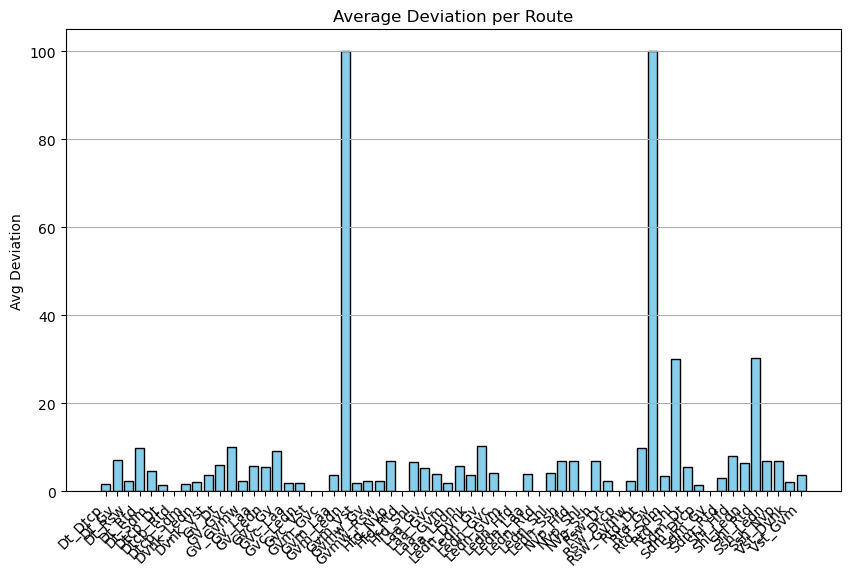

In [31]:
# Group by route
route_stats = df.groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean"
}).reset_index()

plt.figure(figsize=(10,6))
plt.bar(route_stats["TRAJECT"], route_stats["AFWIJKING"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg Deviation")
plt.title("Average Deviation per Route")
plt.grid(axis="y")
plt.show()

# Quality of previsions through the day

We group the realised departures times in 10-minutes intervals

In [20]:
# Creation of multiple time intervals to group the trips

quality_of_previsions = df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

# convert to datetime
quality_of_previsions["round_UITVOERTIJD_AANKOMST"] = quality_of_previsions["UITVOERTIJD_AANKOMST"].apply(
    lambda td: (datetime.min + td).time() 
)

# We create a new feature to group the real departure times by 10-minutes intervals 
def round_time_to_interval(t,interval=10):
    """
    It rounds a time of date format 
    Args : 
        t : time in datetime format
        interval (int) : interval for the rounding (exemple : 10-minutes intervals)
    Retunrs : 
        rounded time in date format
    """
    if t is pd.NaT or t is None:
        return None
    dt = datetime.combine(datetime.today(), t)
    total_minutes = dt.hour * 60 + dt.minute
    rounded_minutes = round(total_minutes / interval) * interval
    dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(minutes=rounded_minutes)
    return dt_rounded.time()

quality_of_previsions["round_UITVOERTIJD_AANKOMST"] = quality_of_previsions["round_UITVOERTIJD_AANKOMST"].apply(lambda t : round_time_to_interval(t,10))

mean_deviation = quality_of_previsions.groupby('round_UITVOERTIJD_AANKOMST').agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
}).reset_index()



And plot the diagram

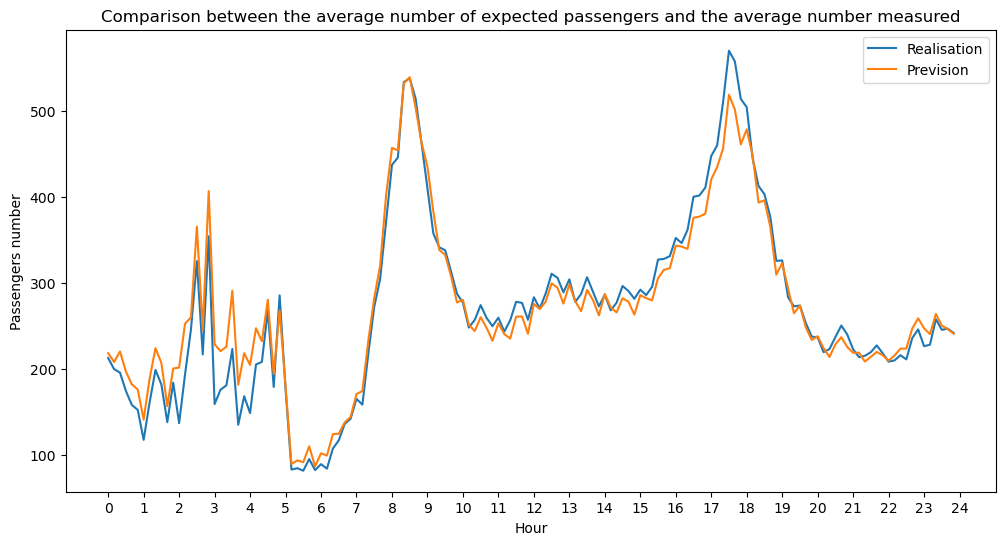

In [21]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)
mean_deviation['minutes'] = mean_deviation['round_UITVOERTIJD_AANKOMST'].apply(
    lambda t: t.hour * 60 + t.minute
)

# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_deviation['minutes'], mean_deviation['REALISATIE'], label='Realisation')
plt.plot(mean_deviation['minutes'], mean_deviation['PROGNOSE_REIZEN'], label='Prevision')

plt.xticks(range(0, 24*60+1, 60), [f"{h}" for h in range(25)])  # ticks every hours
plt.xlabel("Hour")
plt.ylabel("Passengers number")
plt.title("Comparison between the average number of expected passengers and the average number measured")
plt.legend()
plt.show()

# Prevision error compared to the delay of the train at departure time

In [22]:
# We group the delays to intervals of 30 secondes for a nice plot

error_compared_to_delay = df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

error_compared_to_delay["delay"] =pd.to_datetime(error_compared_to_delay["delay"], format="%H:%M:%S").dt.time

def round_time_to_interval_seconds(t, interval_seconds=30):
    """
    It rounds a time of date format 
    Args : 
        t : time in datetime format
        interval (int) : interval for the rounding (exemple : 10-seconds intervals)
    Retunrs : 
        rounded time in date format
    """
    dt = datetime.combine(datetime.today(), t)
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second
    rounded_seconds = round(total_seconds / interval_seconds) * interval_seconds
    dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=rounded_seconds)
    return dt_rounded.time()


error_compared_to_delay["delay_round"] = error_compared_to_delay["delay"].apply(lambda t : round_time_to_interval_seconds(t,30))


In [23]:
# We group the values for each delay interval for a nice plot

mean_delay = error_compared_to_delay.groupby("delay_round").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
    'AFWIJKING' : "mean",
}).reset_index()

mean_delay=mean_delay.loc[mean_delay["delay_round"] < time(hour=2)]


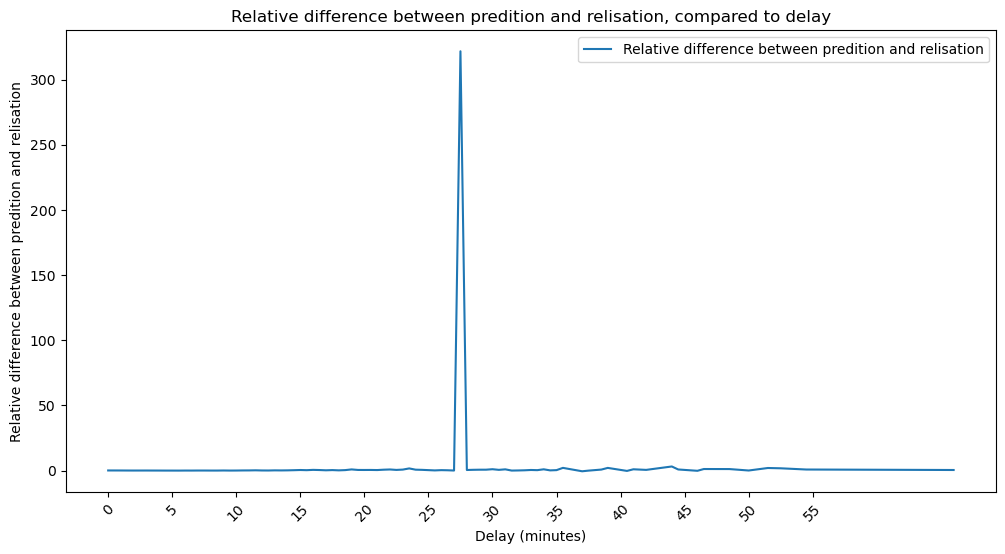

In [24]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)


mean_delay['seconds'] = mean_delay["delay_round"].apply(
    lambda t: t.hour * 3600 + t.minute*60 + t.second)


# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_delay['seconds'], mean_delay['AFWIJKING'], label='Relative difference between predition and relisation')


ticks = range(0, 3600, 300)  # tous les 5 minutes (300 secondes)
labels = [f"{m}" for m in range(0, 60, 5)]
plt.xticks(ticks, labels, rotation=45)
plt.xlabel("Delay (minutes)")
plt.ylabel('Relative difference between predition and relisation')
plt.title('Relative difference between predition and relisation, compared to delay')
plt.legend()
plt.show()

#the pic is due to an aberration at 27:30 delay --->>> DATA CLEANING

# Average delay on all of the network 

First, we have to group the line of the dataframes to only get 1 delay per train. 
But for this purpose, two approaches can be used. Lets take the example of a train running from Shl to Gvc. Let's say that this train has a 11min38 delay from Shl to Hfd, 11min43 delay from Hfd to Ledn, and a 11min35 delay from Ledn to Gvc (it catches up a little on the last section). 
- First approach : we take the maximum delay encountered by the train. For this example, it should be 11min43
- Second approach : we take te final delay of the train at it's final station. For this example, it should be 11min35.

I think that the second approach is the most relevant one, but the two of them are written below, and one just need to comment/uncomment the two lines.

In [46]:
df_delay_per_train= df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

df_delay_per_train["delay"] =pd.to_datetime(df_delay_per_train["delay"], format="%H:%M:%S").dt.time
df_delay_per_train["delay_seconds"] = df_delay_per_train["delay"].apply(lambda t: t.hour*3600 + t.minute*60 + t.second)

#FIRST APPROACH : 
#idx = df_delay_per_train.groupby(["DAGNR", "BEWEGINGNUMMER"])["delay_seconds"].idxmax()

#SECOND APPROACH : 
idx = df_delay_per_train.groupby(["DAGNR", "BEWEGINGNUMMER"]).tail(1).index


df_delay_per_train = df_delay_per_train.loc[idx].reset_index(drop=True)

def mean_delays(period, df) : 
    df_selection = df.loc[df["DAGDEELTREIN"]==period]
    mean = df_selection["delay_seconds"].mean()
    return (datetime.min + timedelta(seconds=mean)).time()

morning = mean_delays("Ochtendspits", df_delay_per_train)
evening = mean_delays("Avondspits", df_delay_per_train)
offpeak = mean_delays("Daluren", df_delay_per_train)
weekend = mean_delays("Weekend", df_delay_per_train)

print(
    f"Mean delay in the morning peak: {morning.hour} hour(s) {morning.minute} minute(s) {morning.second} second(s) \n"
    f"Mean delay in the evening peak: {evening.hour} hour(s) {evening.minute} minute(s) {evening.second} second(s) \n"
    f"Mean delay in the off peak: {offpeak.hour} hour(s) {offpeak.minute} minute(s) {offpeak.second} second(s)\n"
    f"Mean delay in the week-end: {weekend.hour} hour(s) {weekend.minute} minute(s) {weekend.second} second(s)"
)

Mean delay in the morning peak: 0 hour(s) 1 minute(s) 4 second(s) 
Mean delay in the evening peak: 0 hour(s) 1 minute(s) 38 second(s) 
Mean delay in the off peak: 0 hour(s) 1 minute(s) 18 second(s)
Mean delay in the week-end: 0 hour(s) 1 minute(s) 8 second(s)


# Influence of small delays


## Propagation of delays

We want to know, if a train is delayed, what is the influence of the trains after occupying the same infrastructure. For this purpose, we define a new attribute "order infrastructure" on intermediate sections.

In [9]:
small_delays = intermediate_sections.copy()
small_delays['UITVOERTIJD_VERTREK_dt'] = small_delays['UITVOERTIJD_VERTREK']
mask_early = small_delays['UITVOERTIJD_VERTREK_dt'] < pd.Timedelta(hours=5)
small_delays.loc[mask_early, 'UITVOERTIJD_VERTREK_dt'] += pd.Timedelta(days=1)

small_delays["delay"] = pd.to_datetime(small_delays["delay"], format="%H:%M:%S").dt.time
small_delays['delay_seconds'] = (small_delays['delay'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second))

small_delays['ORDER_ON_INFRA'] = (
    small_delays
    .sort_values(by=['DAGNR', 'station1', 'station2', 'UITVOERTIJD_VERTREK_dt'])
    .groupby(['DAGNR', 'station1', 'station2'])
    .cumcount() + 1  # 
)

In [10]:
def select_following_trains(i) : 
    """
    It selects the trains 20 next trains that run on the same infrastructure after train of index i
    Args : 
        i (int) : index of the train we want to consider
    Returns : 
        select (DataFrame) : attributes of the20 next trains that run on the same infrastructure 
        after train of index i
    """
    select = small_delays.loc[
                    (small_delays["ORDER_ON_INFRA"] >= small_delays.loc[i, "ORDER_ON_INFRA"]) &
                    (small_delays["ORDER_ON_INFRA"] < small_delays.loc[i, "ORDER_ON_INFRA"] + 20) & 
                    (small_delays["station1"] ==  small_delays.loc[i, "station1"]) & 
                    (small_delays["station2"] == small_delays.loc[i, "station2"]) & 
                    (small_delays["DAGNR"] == small_delays.loc[i, "DAGNR"]) &
                    (~ pd.isna(small_delays["delay"]))].reset_index()
    
    
    select.sort_values(by='ORDER_ON_INFRA', inplace=True)
    select.reset_index(drop=True, inplace=True)
    return select


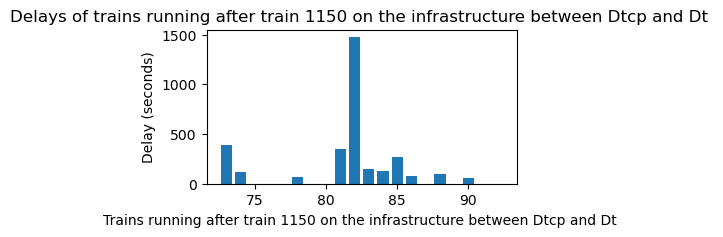

In [11]:
i = 74996 # index in table small_delays (found manually)

plt.figure(figsize=(4, 2))
plt.bar(select_following_trains(i)['ORDER_ON_INFRA'], select_following_trains(i)['delay_seconds'])
plt.xlabel(f"Trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} " )
plt.ylabel('Delay (seconds)')
plt.title(f'Delays of trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} ')
plt.show()


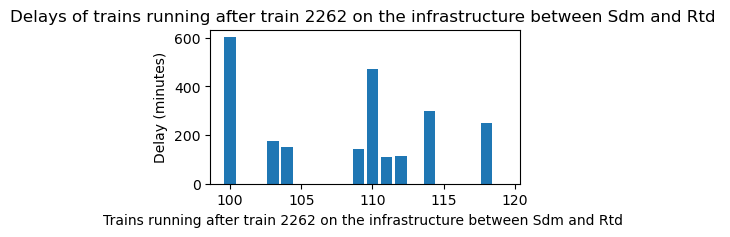

In [12]:
i = 164 # index in table small_delays 

plt.figure(figsize=(4, 2))
plt.bar(select_following_trains(i)['ORDER_ON_INFRA'], select_following_trains(i)['delay_seconds'])
plt.xlabel(f"Trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} " )
plt.ylabel('Delay (minutes)')
plt.title(f'Delays of trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} ')
plt.show()

Now we represent the average delays (before, we would only focus on a specific train)

In [14]:
def plot_propagation_of_delays_by_type(minute):
    """
    Plots the propagation of delays for the next 20 trains grouped by type of train (TGV, Sprinter, IC)
    
    Args:
        minute (int): delay we want to consider
        small_delays (pd.DataFrame): dataframe containing train delays
    """
    interval = [60 * minute - 30, 60 * minute + 30]

    # Select the trains in the interval
    base_trains = small_delays.loc[
        (small_delays["delay_seconds"] >= interval[0]) &
        (small_delays["delay_seconds"] < interval[1])
    ]

    merged = base_trains.merge(
        small_delays,
        on=["station1", "station2", "DAGNR"],
        suffixes=("_base", "_other")
    )
    merged["delta_order"] = merged["ORDER_ON_INFRA_other"] - merged["ORDER_ON_INFRA_base"]

    merged = merged[(merged["delta_order"] >= 0) & (merged["delta_order"] <= 20)]

    # Define train types to plot
    train_types = ["TGV", "Sprinter", "IC"]

    # Compute mean delay per delta_order for each type
    df_list = []
    for ttype in train_types:
        df_t = (
            merged[merged["TYPE_OF_TRAIN_other"] == ttype]
            .groupby("delta_order")["delay_seconds_other"]
            .mean()
            .reset_index()
            .rename(columns={"delta_order": "ORDER_ON_INFRA_INDEX", "delay_seconds_other": ttype})
        )
        df_list.append(df_t)

    # Merge all types into a single dataframe
    from functools import reduce
    df_mean = reduce(lambda left, right: pd.merge(left, right, on="ORDER_ON_INFRA_INDEX", how="outer"), df_list)
    df_mean = df_mean.fillna(0)  # fill NaN with 0 for plotting

    # Plot grouped bar chart
    x = np.arange(len(df_mean["ORDER_ON_INFRA_INDEX"]))  # the label locations
    width = 0.25  # width of the bars

    plt.figure(figsize=(5, 3))
    plt.bar(x - width, df_mean["TGV"], width, label="TGV")
    plt.bar(x, df_mean["Sprinter"], width, label="Sprinter")
    plt.bar(x + width, df_mean["IC"], width, label="IC")

    plt.xlabel("Trains running on same infra after the 1st delayed train, ordered")
    plt.ylabel("Average delay (seconds)")
    plt.title(f"Propagation of delays for trains around {minute} minutes delay")
    plt.xticks(x, df_mean["ORDER_ON_INFRA_INDEX"])
    plt.legend()
    plt.tight_layout()
    plt.show()

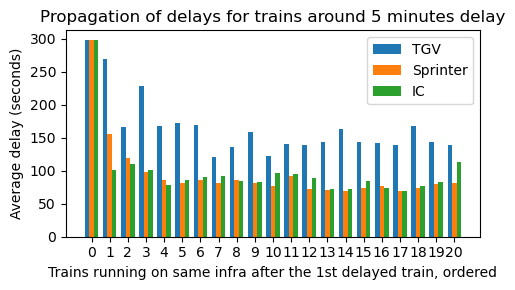

In [15]:
minute = 5
plot_propagation_of_delays_by_type(minute)

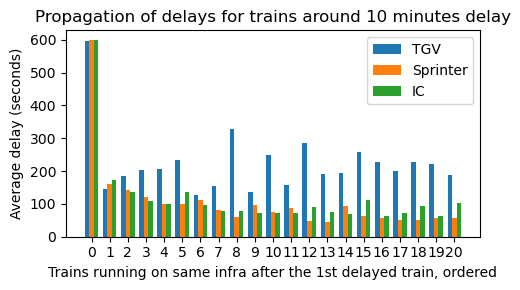

In [16]:
minute = 10
plot_propagation_of_delays_by_type(minute)


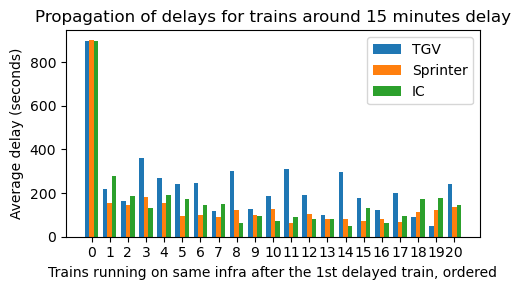

In [17]:
minute = 15
plot_propagation_of_delays_by_type(minute)

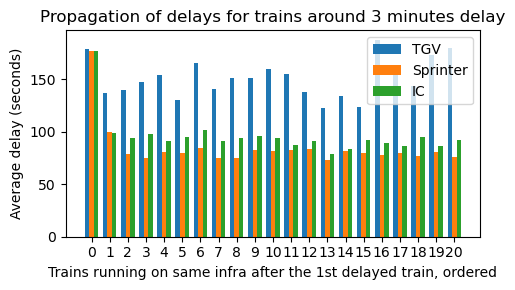

In [18]:
minute = 3
plot_propagation_of_delays_by_type(minute)

Without making a differenciation on the type of train :

In [19]:
def plot_propagation_of_delays(minute, small_delays, mode):
    """
    It plots the delays encountered by the 20 next trains running on the same infrastructure that the 
    train that encountered the 1st delay
    Args : 
        minute (int) : delay we want to consider
    Returns : 
    """
    interval = [60 * minute - 30, 60 * minute + 30]

    # Select the trains in the interval
    base_trains = small_delays.loc[
        (small_delays["delay_seconds"] >= interval[0]) &
        (small_delays["delay_seconds"] < interval[1])
    ]

    merged = base_trains.merge(
        small_delays,
        on=["station1", "station2", "DAGNR"],
        suffixes=("_base", "_other")
    )
    merged["delta_order"] = merged["ORDER_ON_INFRA_other"] - merged["ORDER_ON_INFRA_base"]

    merged = merged[(merged["delta_order"] >= 0) & (merged["delta_order"] <= 20)]

    if mode == "Average" : 
        df_agg = (
            merged.groupby("delta_order")["delay_seconds_other"]
            .mean()
            .reset_index()
            .rename(columns={"delta_order": "ORDER_ON_INFRA_INDEX", "delay_seconds_other": "mean_delay_seconds"})
        )

    if mode == "Maximum" : 
        df_agg = (
            merged.groupby("delta_order")["delay_seconds_other"]
            .max()
            .reset_index()
            .rename(columns={"delta_order": "ORDER_ON_INFRA_INDEX", "delay_seconds_other": "mean_delay_seconds"})
        )
    # Plot the figure
    plt.figure(figsize=(4, 3))
    plt.bar(df_agg["ORDER_ON_INFRA_INDEX"], df_agg["mean_delay_seconds"])
    plt.xlabel("Trains running on same infra after the 1st delayed train, ordered")
    plt.ylabel(f"{mode} delay (seconds)")
    plt.title(f"Propagation of delays for trains around {minute} minutes delay")
    plt.tight_layout()
    plt.show()


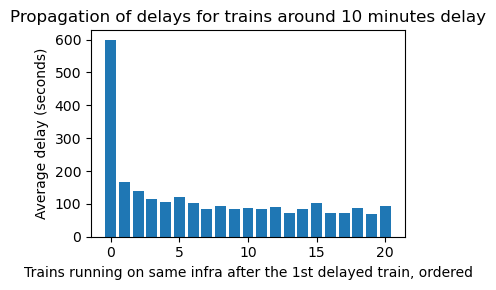

In [18]:
minute = 10
plot_propagation_of_delays(minute)

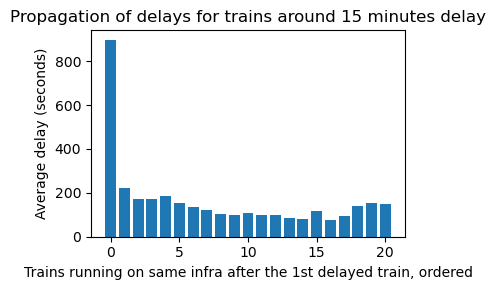

In [20]:
minute = 15
plot_propagation_of_delays(minute,small_delays, "Average")

Taking the maximum instead of the average : 

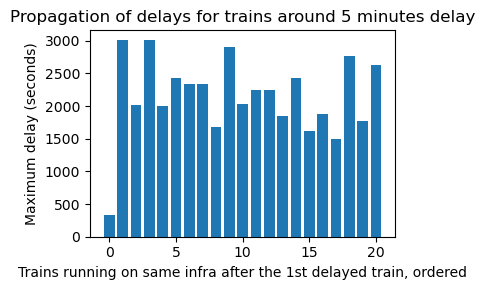

In [21]:
minute = 5
plot_propagation_of_delays(minute,small_delays, "Maximum")

As a conclusion, we cannot observe, with this data, the propagation of delays on trains running on the same infrastructure

## Crowding of trains after small delays

We want to know, when a train is delayed before it's terminus station, if it will be more crowded than forecasted on the rest of it's trip 

In [22]:
# Creation of a new attribute : IS_TERMINUS 

df_small_delays = df.copy()
df_small_delays['IS_TERMINUS'] = (
    df_small_delays.groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount(ascending=False) == 0
)
df_small_delays["delay"] = pd.to_datetime(df_small_delays["delay"], format="%H:%M:%S").dt.time
df_small_delays['delay_seconds'] = (df_small_delays['delay'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second))


In [23]:
# Select the trains that are delayed of a certain amount of time, but not at their terminus  
# stations (to observe the rest of their journey)

def make_list_index (minute) : 
    """
    It selects all the trains that are delayed BEFORE their terminus of a certain amount of minutes 
    (between minute-30 and minute+30)
    Args : 
        minute (int) : delay we want to consider
    Returns : 
        lst_index (list) : indexes of all the trains delayed before their terminus
    """
    interval = [60 * minute - 30, 60 * minute + 30]
    list_index = df_small_delays.loc[
        (df_small_delays["delay_seconds"] >= interval[0]) &
        (df_small_delays["delay_seconds"] < interval[1])&
        (df_small_delays["IS_TERMINUS"] == False) &
        (~ pd.isna(df_small_delays["delay_seconds"]))].index.tolist()
    return list_index
    

In [24]:
# Select the rest of their journeys after they encounter their first delay

minute =5

df_selected = df_small_delays.loc[make_list_index (minute)]
final_indices = set(make_list_index (minute)) 

for index in make_list_index (minute):
    row = df_small_delays.loc[index]
    mask = (
        (df_small_delays.index > index) &
        (df_small_delays['BEWEGINGNUMMER'] == row['BEWEGINGNUMMER']) &
        (df_small_delays['DAGNR'] == row['DAGNR'])
    )
    final_indices.update(df_small_delays.index[mask])

df_result = df_small_delays.loc[sorted(final_indices)]


In [25]:
# Order the rest of the services after the appartition of the delay

df_result['ORDER_ON_SERVICE'] = (
    df_result
    .groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount() 
)

In [26]:
def plot_propagation_of_deviation(df_arg):
    """
    It plots, on one side, the deviation in prediction for the sections run by the same train after 
    the apparition of the delay
    Args : 
        df_arg (DataFrame) : df with all the sections run by a train after it is delayed 
    Returns : 
    """
    df_mean = (
                df_arg.groupby("ORDER_ON_SERVICE")["AFWIJKING"]
                .agg(mean_deviation=lambda x: x.abs().mean(), 
                     counted_data="count")
                .reset_index()
                .rename(columns={"ORDER_ON_SERVICE": "order_on_service"})
                )

    x = np.arange(len(df_mean)) # Positions of bars on X-axis
    width = 0.4
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # Principal axis : mean_deviation
    bars1 = ax1.bar(x - width/2, df_mean["mean_deviation"], width, label="Mean deviation", color="purple")
    ax1.set_xlabel("Next sections after the apparition of the delay")
    ax1.set_ylabel("Mean deviation", color="purple")
    ax1.tick_params(axis="y", labelcolor="purple")
    ax1.set_ylim(0, df_mean["mean_deviation"].max() * 1.5)
    
    # Secondary axis : counted data
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, df_mean["counted_data"], width, label="Counted data", color="orange", alpha = 0.4)
    ax2.set_ylabel("Counted data", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")
    ax2.set_ylim(0, df_mean["counted_data"].max() * 1.5)
    
    # X-Axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_mean["order_on_service"])
    
    plt.title(f"Propagation of deviation for trains delayed of {minute} minutes before their terminus")
    fig.tight_layout()
    bars = [bars1, bars2]
    labels = [b.get_label() for b in bars]
    ax1.legend(bars, labels, loc="upper left")   
    plt.show()


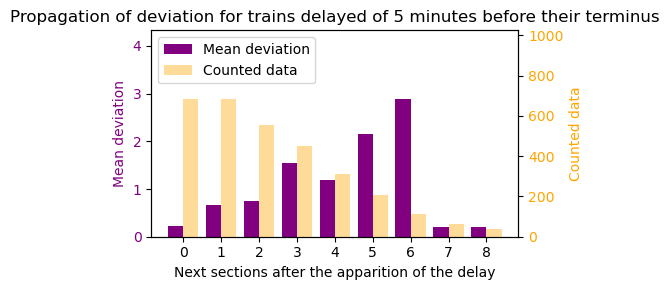

In [27]:
plot_propagation_of_deviation(df_result)

And here is the comparison to the evolution of deviation of all the trains, without considering their delays

In [28]:
df_small_delays['ORDER_ON_SERVICE'] = (
    df_small_delays
    .groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount()  
)

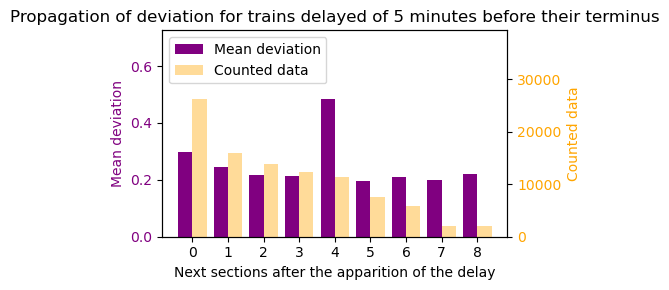

In [29]:
plot_propagation_of_deviation(df_small_delays.loc[(~ pd.isna(df_small_delays["delay_seconds"]))])

### Separate on the infrastructures

Only on the slow line between Rotterdam Central and Shiphol

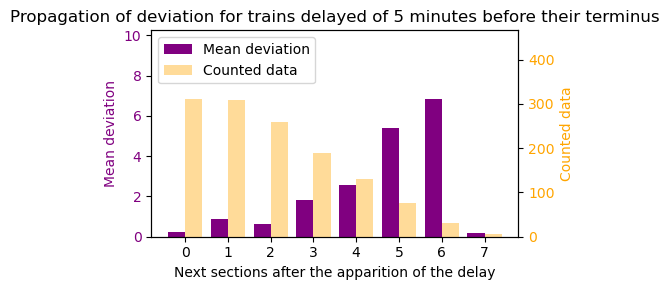

In [30]:
plot_propagation_of_deviation(df_result.loc[df_result["global_infra"].isin(['Slow_Rtd_Shl','Slow_Rtd_Gvc','Slow_Gvc_Shl'])] )

Only on the slow lines between Schiphol and Rotterdam Central

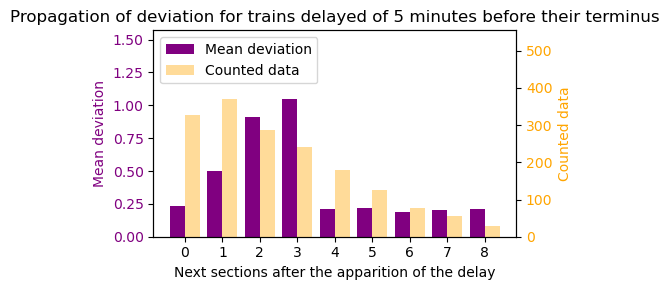

In [31]:
plot_propagation_of_deviation(df_result.loc[df_result["global_infra"].isin(['Slow_Shl_Rtd','Slow_Gvc_Rtd','Slow_Shl_Gvc'])] )


## People changing their journey themselves

We want to check if, for trains with small delays, people board on other trains departing from the same station, instead of waiting for their train to arrive

In [31]:
minute = 10
final_indices_replacement =set() 

for idx in make_list_index (minute) :
    row = df_small_delays.loc[idx]
    mask = (
        (df_small_delays['UITVOERTIJD_VERTREK'] > row['PLANTIJD_VERTREK']) &
        (df_small_delays['UITVOERTIJD_VERTREK'] < row['PLANTIJD_VERTREK']+pd.to_timedelta(f"{minute} minutes")) &
        (df_small_delays['DAGNR'] == row['DAGNR'])& 
        (df_small_delays['station1'] == row['station2'])&
        (~ pd.isna(df_small_delays["delay_seconds"]))
    )
    final_indices_replacement.update(df_small_delays.index[mask])

df_replacement_final = df_small_delays.loc[sorted(final_indices_replacement)]

In [32]:
mean_deviation_with_delay = df_replacement_final["AFWIJKING"].mean()
mean_deviation_with_delay

np.float64(-0.005602280462291664)

In [33]:
mean_deviation = df_small_delays.loc[(~ pd.isna(df_small_delays["delay_seconds"])),"AFWIJKING"].mean()
mean_deviation

np.float64(0.09498207829783699)

We see that people don't change train in a significative way instead of waiting for their late train to arriveWe see that people don't change train in a significative way instead of waiting for their late train to arrive. Or maybe they do, but we can't evaluate it with the attribute AFWIJKING.